# Introduction 

We consider house price data to predict the price of a house. 

### Importing files

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_train = pd.read_csv('House_price_train.csv')
df_test = pd.read_csv('House_price_test.csv')

In [3]:
print(df_train.shape)
print(df_test.shape)

(1460, 81)
(1459, 80)


### Top affecting variables to the sale price

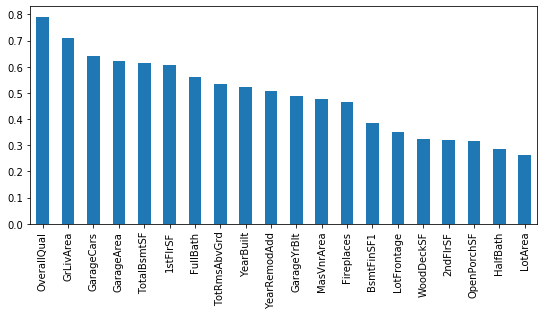

In [4]:
corr_list = df_train.corrwith(df_train['SalePrice']).sort_values(ascending = False)

fig = plt.figure(figsize = (20, 4))

ax = fig.add_subplot(121)
corr_list.iloc[1:21].plot.bar()
plt.show()

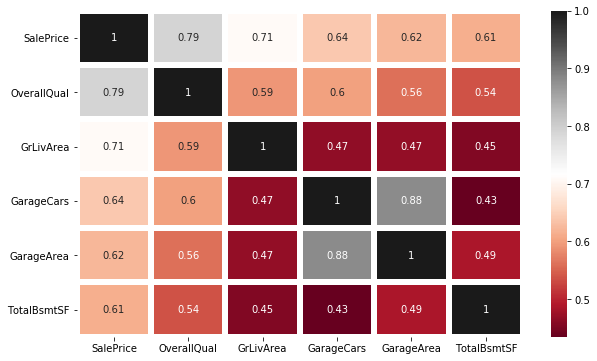

In [5]:
df_top = df_train[corr_list.index[:6]]

plt.subplots(figsize = (10, 6))
sns.heatmap(df_top.corr(), annot = True, linewidths = 5, cmap = 'RdGy')
plt.show()

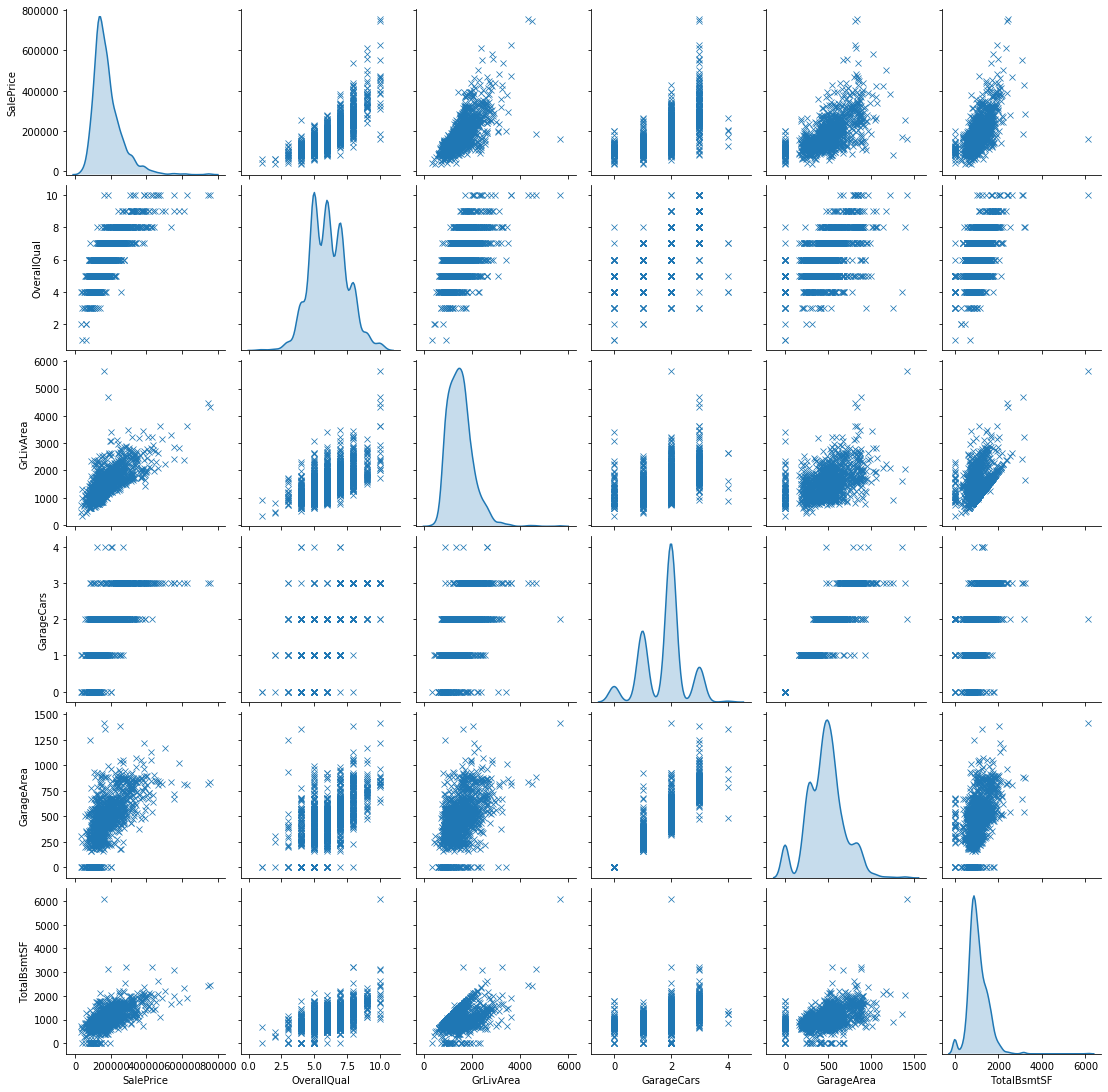

In [6]:
sns.pairplot(df_top, diag_kind = 'kde', markers = 'x')
plt.show()

# Remoginv the outliers 

### Outlier in the range of price

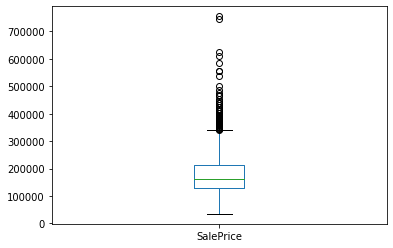

In [7]:
df_train['SalePrice'].plot.box()
plt.show()

In [8]:
quants = df_train['SalePrice'].quantile([0.01, 0.99])
df_train = df_train[df_train['SalePrice'].between(quants.loc[0.01], quants.loc[0.99])]

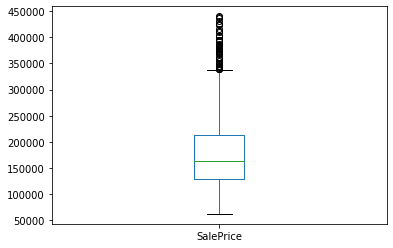

In [9]:
df_train['SalePrice'].plot.box()
plt.show()

### Large house sold for low price 

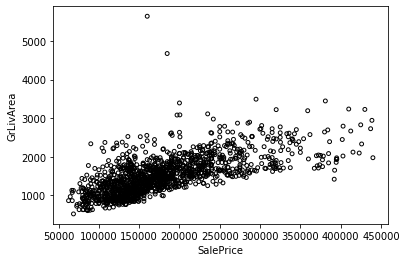

In [10]:
plt.scatter(df_train['SalePrice'], df_train['GrLivArea'], s = 15, facecolors = 'none', edgecolors = 'k')
plt.xlabel('SalePrice')
plt.ylabel('GrLivArea')
plt.show()

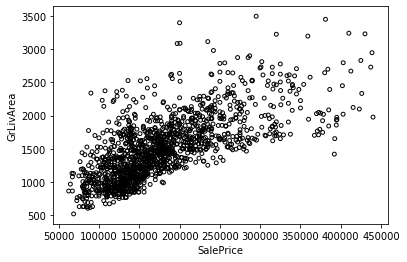

In [11]:
df_train = df_train[df_train['GrLivArea'] < 4000]

plt.scatter(df_train['SalePrice'], df_train['GrLivArea'], s = 15, facecolors = 'none', edgecolors = 'k')
plt.xlabel('SalePrice')
plt.ylabel('GrLivArea')
plt.show()

### Large Garage area in cheap price 

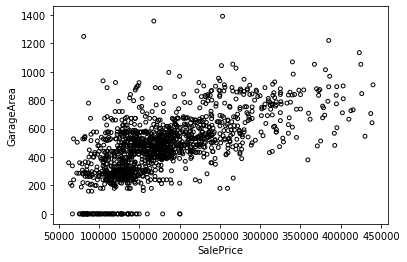

In [12]:
plt.scatter(df_train['SalePrice'], df_train['GarageArea'], s = 15, facecolors = 'none', edgecolors = 'k')
plt.xlabel('SalePrice')
plt.ylabel('GarageArea')
plt.show()

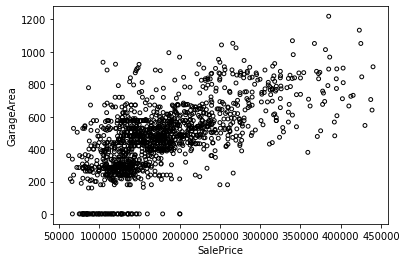

In [13]:
df_train = df_train[df_train['GarageArea'] < 1230]

plt.scatter(df_train['SalePrice'], df_train['GarageArea'], s = 15, facecolors = 'none', edgecolors = 'k')
plt.xlabel('SalePrice')
plt.ylabel('GarageArea')
plt.show()

### Large Basement area 

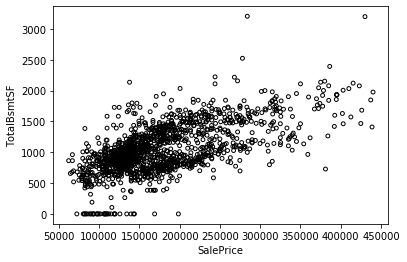

In [14]:
plt.scatter(df_train['SalePrice'], df_train['TotalBsmtSF'], s = 15, facecolors = 'none', edgecolors = 'k')
plt.xlabel('SalePrice')
plt.ylabel('TotalBsmtSF')
plt.show()

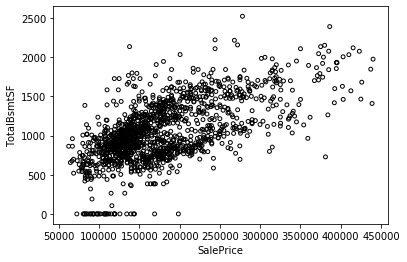

In [15]:
df_train = df_train[df_train['TotalBsmtSF'] < 3000]

plt.scatter(df_train['SalePrice'], df_train['TotalBsmtSF'], s = 15, facecolors = 'none', edgecolors = 'k')
plt.xlabel('SalePrice')
plt.ylabel('TotalBsmtSF')
plt.show()

### Price outliers in overall quality classes

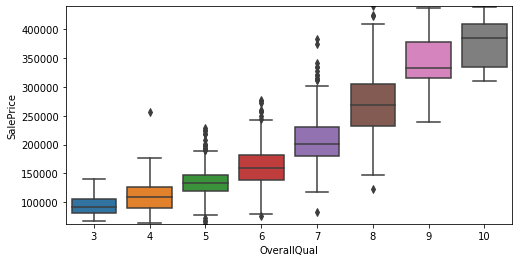

In [16]:
f, ax = plt.subplots(figsize=(8, 4))
fig = sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = df_train[['SalePrice', 'OverallQual']])
fig.axis(ymin = df_train['SalePrice'].min(), \
         ymax = df_train['SalePrice'].max());

In [17]:
def category_perct(df, colname):
    mini_df = df[['SalePrice', colname]].groupby([colname]).quantile([0.01, 0.99])['SalePrice']
    return mini_df

def remove_outlier(df, colname, category):
    perct_by = category_perct(df, colname)
    cond = (df[colname] == category) & \
          ((df['SalePrice'] < perct_by.loc[category].iloc[0]) | \
           (df['SalePrice'] > perct_by.loc[category].iloc[1]))
    ind = df[cond].index
    return ind

def remove_OverallQual(df, start, finish):
    ind_list = [remove_outlier(df, 'OverallQual', i) for i in range(start, 1 + finish)]
    ind_union = ind_list[0]
    for i in range(len(ind_list)):
        ind_union = ind_union.union(ind_list[i])
    return ind_union

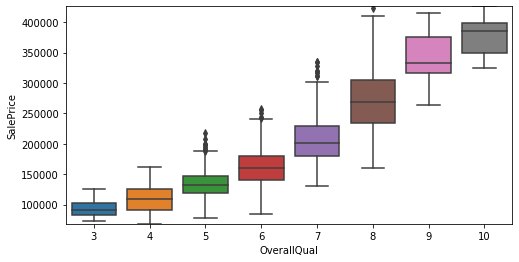

In [18]:
df_train = df_train.drop(remove_OverallQual(df_train, 3, 10))

f, ax = plt.subplots(figsize=(8, 4))
fig = sns.boxplot(x = 'OverallQual', y = 'SalePrice', data = df_train[['SalePrice', 'OverallQual']])
fig.axis(ymin = df_train['SalePrice'].min(), \
         ymax = df_train['SalePrice'].max());

# Data Preprocessing 

### Target, features, train, test

In [19]:
X_train = df_train.drop(['SalePrice', 'Id'], axis = 1)
X_test = df_test.drop('Id', axis = 1)

y_train = df_train['SalePrice']

In [20]:
print(df_train.shape, df_test.shape)
print(X_train.shape, X_test.shape)

(1386, 81) (1459, 80)
(1386, 79) (1459, 79)


### Distrubution of sale price 

In [21]:
y_train.isnull().sum()

0

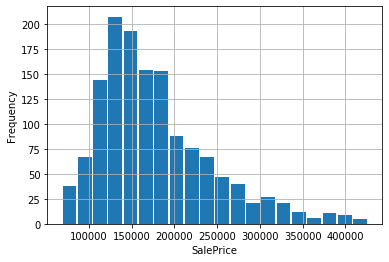

In [22]:
y_train.plot.hist(grid = True, bins = 20, rwidth = 0.9)
plt.xlabel('SalePrice')
plt.show()

### Log transformation to the skewed distribution

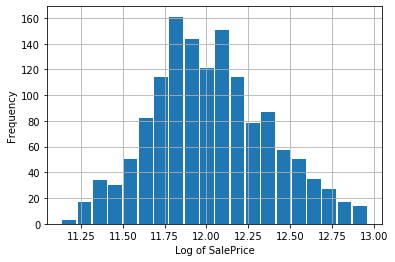

In [23]:
y_train = y_train.transform(np.log1p)

y_train.plot.hist(grid = True, bins = 20, rwidth = 0.9)
plt.xlabel('Log of SalePrice')
plt.show()

In [24]:
len_train = len(X_train)
X = pd.concat([X_train, X_test])

In [25]:
len_train

1386

In [26]:
num_feat = X.dtypes[X.dtypes != 'object'].index
skewness = X[num_feat].skew() 
skew_feat = skewness[skewness > 1].index
X[skew_feat] = X[skew_feat].transform(np.log1p)

### Missing data 

In [27]:
X = X.fillna(X.median())

### Dummies for categorical variables 

In [28]:
X = pd.get_dummies(X)

In [29]:
X_train, X_test = X[:len_train], X[len_train:]

In [30]:
print(df_train.shape, df_test.shape)
print(X_train.shape, X_test.shape)

(1386, 81) (1459, 80)
(1386, 286) (1459, 286)


# Model building 

In [31]:
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve, learning_curve
from sklearn.metrics import mean_squared_error

### Simple linear regression

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print('R2: \t\t', lr.score(X_train, y_train))

y_pred_lr = lr.predict(X_train)
print('MSE: \t\t', np.sqrt(mean_squared_error(y_train, y_pred_lr)))

R2: 		 0.953526157946495
MSE: 		 0.0755683139179842


In [33]:
cross_val_score(lr, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 5).mean()

-0.10855885209599585

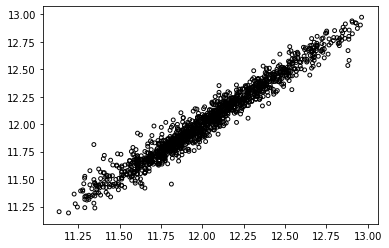

In [34]:
plt.scatter(y_train, y_pred_lr, s = 15, facecolors = 'none', edgecolors = 'k')
plt.show()

Top features choosen by regression are different than those we see earlier based on correlation with the sales price. This is due to the multicollinearity. 

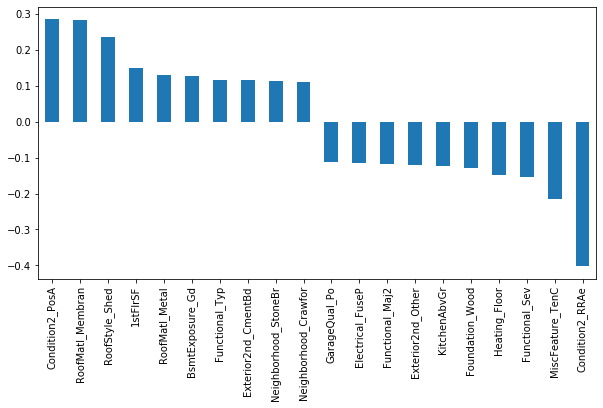

In [37]:
coef = pd.Series(lr.coef_, index = X_train.columns)
coef_sorted = coef.sort_values(ascending=False)
coef_top = pd.concat([coef_sorted.head(10), coef_sorted.tail(10)])

plt.figure(figsize = (10, 5))
coef_top.plot.bar()
plt.show()

Learning rate 

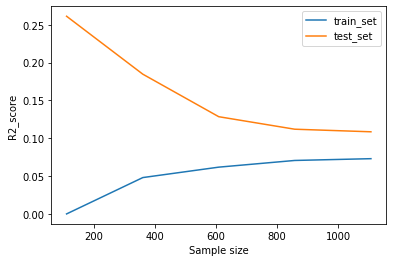

In [38]:
n_train, train_scores, test_scores = learning_curve(lr, \
                                                   X_train, y_train, scoring = 'neg_root_mean_squared_error')

plt.plot(n_train, -np.mean(train_scores, axis=1))
plt.plot(n_train, -np.mean(test_scores, axis=1))
plt.xlabel('Sample size')
plt.ylabel('R2_score')
plt.legend(['train_set', 'test_set'])
plt.show()

### Ridge regression 

In [39]:
alphas = [0.001, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60, 100, 300, 600, 1000]

train_scores, test_scores = validation_curve(Ridge(), X_train, y_train, 'alpha', \
                                              alphas, scoring = 'neg_root_mean_squared_error', cv=5)

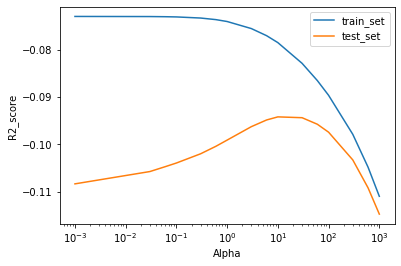

In [40]:
plt.plot(alphas, np.mean(train_scores, axis=1))
plt.plot(alphas, np.mean(test_scores, axis=1))
plt.xlabel('Alpha')
plt.ylabel('R2_score')
plt.legend(['train_set', 'test_set'])
plt.xscale('log')
plt.show()

In [41]:
ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)
print('R2: \t\t', ridge.score(X_train, y_train))

y_pred_ridge = ridge.predict(X_train)
print('MSE: \t\t', np.sqrt(mean_squared_error(y_train, y_pred_ridge)))

R2: 		 0.9481647074445902
MSE: 		 0.07980832950027307


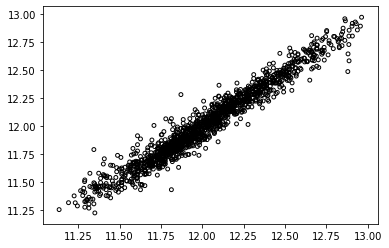

In [42]:
plt.scatter(y_train, y_pred_ridge, s = 15, facecolors = 'none', edgecolors = 'k')
plt.show()

Top features choosen by ridge regression are different than the top features chosen by simple linear regression and also they are different than those we see earlier based on correlation with the sales price. 

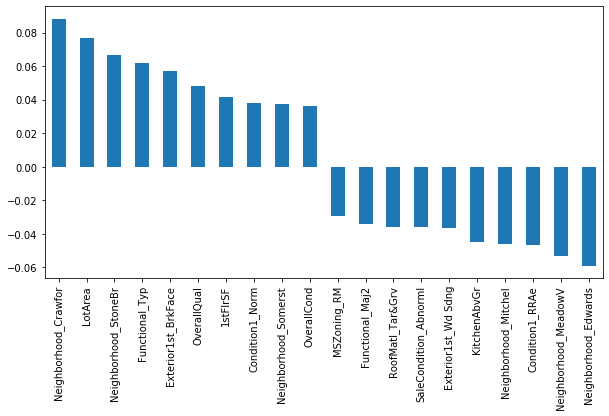

In [43]:
coef = pd.Series(ridge.coef_, index = X_train.columns)
coef_sorted = coef.sort_values(ascending=False)
coef_top = pd.concat([coef_sorted.head(10), coef_sorted.tail(10)])

plt.figure(figsize = (10, 5))
coef_top.plot.bar()
plt.show()

Learning rate 

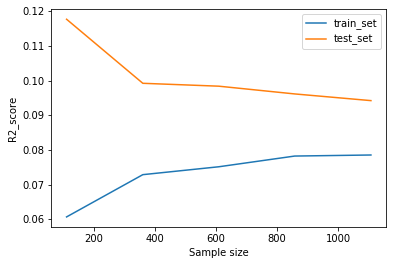

In [44]:
n_train, train_scores, test_scores = learning_curve(Ridge(alpha=10), \
                                                   X_train, y_train, scoring = 'neg_root_mean_squared_error')

plt.plot(n_train, -np.mean(train_scores, axis=1))
plt.plot(n_train, -np.mean(test_scores, axis=1))
plt.xlabel('Sample size')
plt.ylabel('R2_score')
plt.legend(['train_set', 'test_set'])
plt.show()

### Lasso 

In [45]:
alpha_list = np.geomspace(0.000001, 1, num=20)
lasso = LassoCV(alphas = alpha_list, max_iter = 20000).fit(X_train, y_train)

In [46]:
print('R2: \t\t', lasso.score(X_train, y_train))

y_pred_lasso = lasso.predict(X_train)
print('MSE: \t\t', np.sqrt(mean_squared_error(y_train, y_pred_lasso)))

R2: 		 0.9446283469137067
MSE: 		 0.0824857994935453


Features picked by Lasso are again different than the top features we noticed earlier 

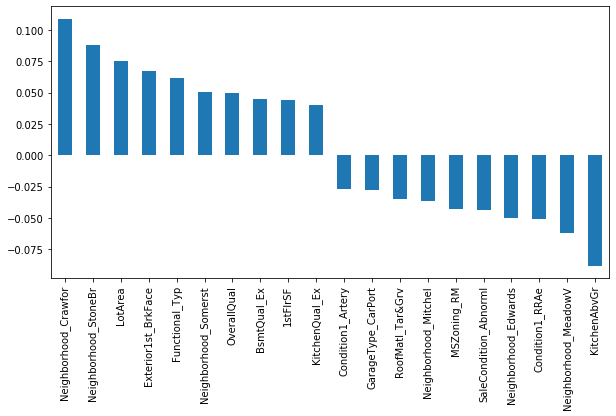

In [47]:
coef = pd.Series(lasso.coef_, index = X_train.columns)
coef_sorted = coef.sort_values(ascending=False)
coef_top = pd.concat([coef_sorted.head(10), coef_sorted.tail(10)])

plt.figure(figsize = (10, 5))
coef_top.plot.bar()
plt.show()

### Comparing three 

In [48]:
print('lr: \t\t', cross_val_score(lr, X_train, y_train).mean())
print('ridge: \t\t', cross_val_score(ridge, X_train, y_train).mean())
print('lasso: \t\t', cross_val_score(lasso, X_train, y_train).mean())

lr: 		 0.9031403889363487
ridge: 		 0.927238653625591
lasso: 		 0.9280989719243994


### What is not classified properly?

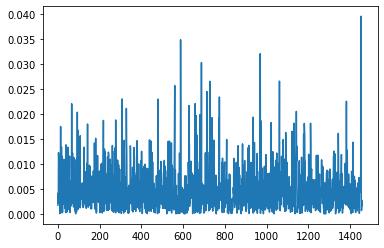

In [52]:
error = np.abs(1 - y_pred_ridge/y_train)

plt.plot(error)
plt.show()

# Kaggel submission file 

In [50]:
y_test_pred_lr = np.expm1(lr.predict(X_test))
y_test_pred_ridge = np.expm1(ridge.predict(X_test))
y_test_pred_lasso = np.expm1(lasso.predict(X_test))

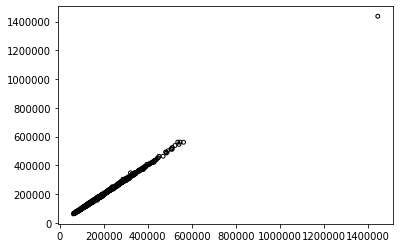

In [51]:
plt.scatter(y_test_pred_lasso, y_test_pred_ridge, s = 15, facecolors = 'none', edgecolors = 'k')
plt.show()

In [88]:
my_submission = pd.DataFrame({'Id': df_test.Id, 'SalePrice': y_test_pred_lr})

my_submission.to_csv('house_price_submission_lr.csv', index=False)

In [89]:
my_submission = pd.DataFrame({'Id': df_test.Id, 'SalePrice': y_test_pred_ridge})

my_submission.to_csv('house_price_submission_ridge.csv', index=False)

In [168]:
my_submission = pd.DataFrame({'Id': df_test.Id, 'SalePrice': y_test_pred_lasso})

my_submission.to_csv('house_price_submission_lasso.csv', index=False)